# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

##### &#9658; [View table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import torch.nn
import torch.optim
import torch.utils.data

In [3]:
import mls.torch

## Design Patterns for Unsupervised Deep Learning

Learning the parameters of a neural network requires a loss function that we can backpropagate to calculate parameter updates. In supervised learning, the loss measures how well a network transforms its input to a target output. For unsupervised learning, we do not have a target value, so instead we must somehow derive one directly from the input. Exactly how we do this will depend on the unsupervised learning task we are trying to solve.

The unsupervised learning tasks that have been successfully tackled with deep learning are:
 - Learn a generative model from data.
 - Learn a probabilistic model from data.
 
Recall that we already saw how to solve these tasks with scikit learn's density estimation algorithms (KNN, GMM, ...).

We will warm up below with the "autoencoder" architecture, then study the following more advanced architectures:
 - Variational autoencoder (VAE)
 - Generative adversarial network (GAN)
 - Flow models

### Test Problem

We start by defining a test problem: learn a (generative and/or probabilistic) model of smooth 1D functions drawn from a Gaussian process prior.

In [4]:
def gpsample(x, ngen, gen, sig0=0.5, lam=0.5):
    """Draw samples from a Gaussian process function prior.
    """
    # Tabulate K for each pair of elements in x.
    xT = x.reshape(-1, 1)
    K = sig0 ** 2 * np.exp(-0.5 * ((xT - x) / lam) ** 2)
    # Generate random samples of f(x).
    mu = np.zeros_like(x)
    return gen.multivariate_normal(mu, K, size=ngen)

Generate independent TRAIN and TEST samples from the same prior:

In [5]:
N_train, N_test, D = 10000, 100, 128
x_sample = np.linspace(-1, 1, D)
gen = np.random.RandomState(seed=123)
x_train = torch.tensor(gpsample(x_sample, ngen=N_train, gen=gen).astype(np.float32))
x_test = torch.tensor(gpsample(x_sample, ngen=N_test, gen=gen).astype(np.float32))

Split into datasets. Note how we duplicate the input as the target, to define a supervised learning task that we can apply all of our previous machinery to:

In [6]:
train_data = torch.utils.data.TensorDataset(x_train, x_train)
test_data = torch.utils.data.TensorDataset(x_test, x_test)

Define a plot utility that we wil re-use below to assess the quality of  predictions $Y_\text{pred}$ from different methods applied to the test data:

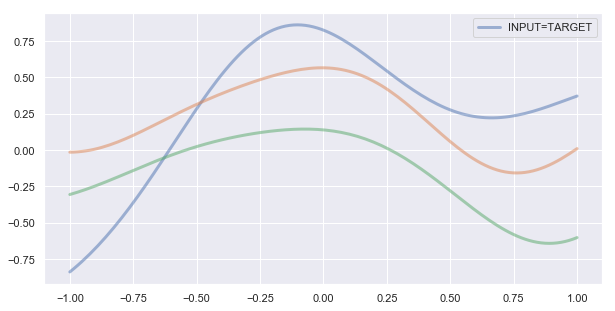

In [7]:
def plot_test(y_pred=None, n_test=3):
    plt.figure(figsize=(10, 5))
    for i in range(n_test):
        x, y = test_data[i]
        plt.plot(x_sample, x.numpy(), '-', lw=3, alpha=0.5, label='INPUT=TARGET' if i == 0 else None)
        if y_pred is not None:
            plt.plot(x_sample, y_pred[i].detach().numpy(), 'k.', ms=2, label='OUTPUT' if i == 0 else None)
    plt.legend(ncol=3)
    
plot_test()

Define a standard learning loop to use for the studies below:

In [8]:
def learn(model, loss_fn, n_epochs=100, batch_size=250, learning_rate=0.05, n_print=1):
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    x_test, y_test = test_data.tensors
    train_loss, test_loss = [], []
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss.data))
        model.eval()
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred, y_test).data))
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    return train_loss, test_loss, y_pred.detach()

### Autoencoder

An "autoencoder" is any network with identical input and output shapes (number of features) that is trained to reproduce each input at its output:

![autoencoder architecture](img/NeuralNetworks/autoencoder.png)

The gray shaded regions represent arbitrary network layers, with heights indicating tensor dimensionality. Note how the input and output heights are the same.

Re-use our fully connected class to build a simple autoencoder:

In [9]:
class FCN(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU):
        super(FCN, self).__init__()
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', torch.nn.LeakyReLU(0.2, inplace=True))

First, use a fully connected (linear) architecture with no hidden nodes:

Model has 16512 parameters.
Data has 1280000 values.
EPOCH   100: TRAIN 0.00000 TEST 0.00000


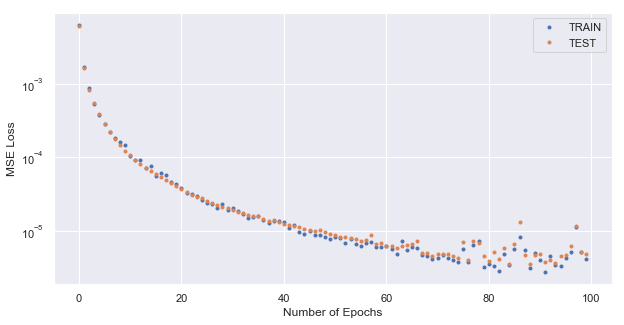

In [10]:
torch.manual_seed(123)
model = FCN(128, 128)
loss_fn = torch.nn.MSELoss()
train_loss, test_loss, y_pred = learn(model, loss_fn, learning_rate=0.002, n_epochs=100)

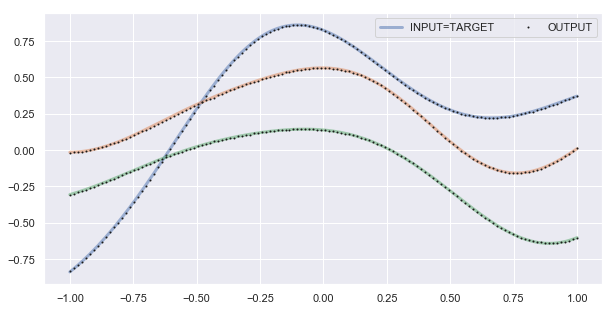

In [11]:
plot_test(y_pred)

This performs extremely well, but has simply learned the identity function $X_\text{out} = X_\text{in}$, rather than anything useful about the actual input distribution, $P(X_\text{in})$.

In order eliminate this trivial solution, we must force the network to learn a representation of the input data in a lower dimensional "latent" space, then expand this representation back into the original space. With a fully connected network, this just means having hidden layers with less than 128 nodes.

For example, if we add a single hidden layer with 6 nodes we can learn a 6-parameter model that approximates the true Gaussian process prior:

Model has 1670 parameters.
Data has 1280000 values.
EPOCH   200: TRAIN 0.00010 TEST 0.00011


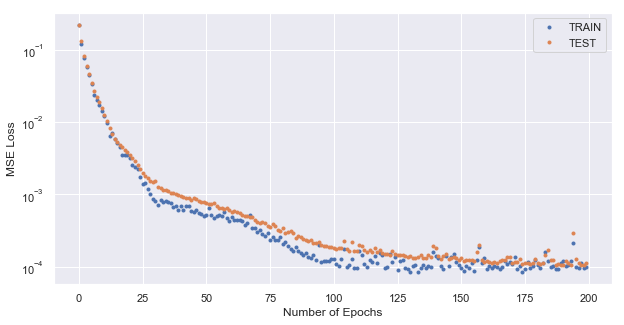

In [12]:
torch.manual_seed(123)
model = FCN(128, 6, 128)
loss_fn = torch.nn.MSELoss()
train_loss, test_loss, y_pred = learn(model, loss_fn, learning_rate=0.002, n_epochs=200)

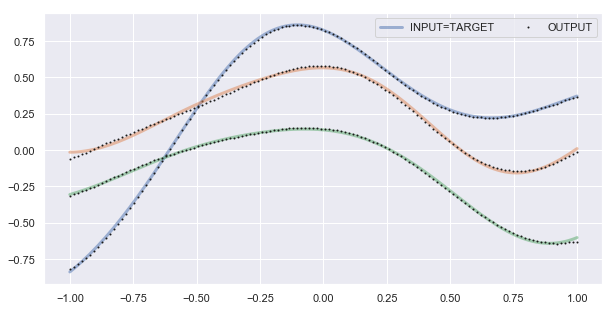

In [13]:
plot_test(y_pred)

To reduce the loss further without changing the latent-space dimension, we can add additional layers to model the transformation from 128 to 6 nodes and back to 128 (but there is not a lot to be gained in this example):

Model has 9542 parameters.
Data has 1280000 values.
EPOCH   250: TRAIN 0.00010 TEST 0.00009


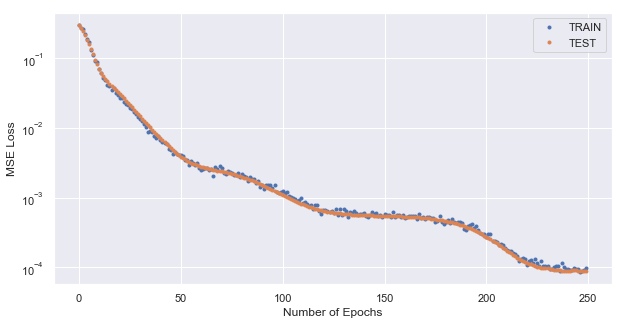

In [14]:
torch.manual_seed(123)
model = FCN(128, 64, 6, 128)
loss_fn = torch.nn.MSELoss()
train_loss, test_loss, y_pred = learn(model, loss_fn, learning_rate=0.0004, n_epochs=250)

What does our input distribution look like when projected into the latent space?  To answer this question we first need to capture the output from the 6-node hidden layer:

In [15]:
mls.torch.trace(model)
y1 = model(x_train[:100])
z1 = model.ACT1.output
y2 = model(x_test[:100])
z2 = model.ACT1.output

Now we can use a seaborn pairplot to compare the latent-space distributions for TRAIN and TEST samples:

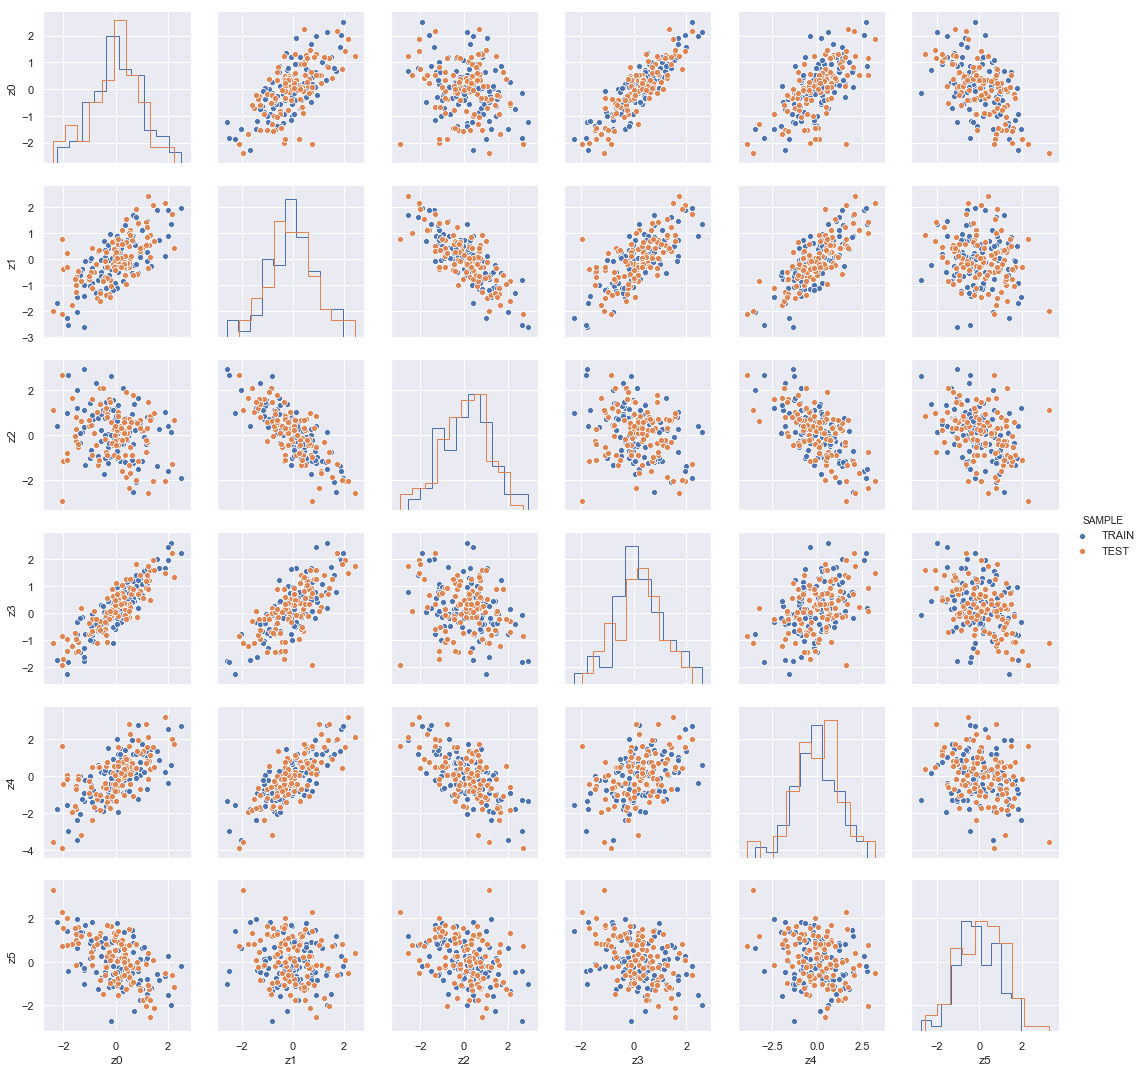

In [16]:
latent_cols = [f'z{k}' for k in range(6)]
df = pd.DataFrame(torch.cat((z1, z2)).numpy(), columns=latent_cols)
df['SAMPLE'] = ['TRAIN'] * 100 + ['TEST'] * 100
sns.pairplot(df, hue='SAMPLE', vars=latent_cols, diag_kind='hist', diag_kws={'histtype': 'step'});

The presence of some strong correlations (e.g., between $z_0$ and $z_3$) indicates that a slightly smaller-dimensional latent representation should be possible. The good agreement (given the limited statistics) between the TRAIN and TEST samples indicates that the model has not been overfit in the latent space (in agreement with the loss curves).

This simple architecture is called an **autoencoder**. Although we used fully connected layers, convolutional layers might work better (or at least more efficiently).

**DISCUSS:** How might you solve these related problems after learning a latent-space model?
 - Estimate the probability density of an arbitrary input, relative to the input distribution ("probabilistic model").
 - Generate a random sample drawn from the input distribution ("generative model").

**SOLUTION:** Both of these problems could be solved using the density estimation methods we [covered earlier](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Density.ipynb). Given the approximately Gaussian distributions above, a Gaussian mixture model (GMM) would be a good approach.

The density estimated from a GMM fit directly solves the first problem. For the second problem, we need two steps:
 - Generate a sample in the latent space.
 - Feed this sample through the "enlarging" layers of the model, that transform the latent space to the output=input space.

---

Much of the recent progress in unsupervised deep learning has been to invent network architectures that are capable of solving either or both of these related problems directly, without resorting to any auxiliary methods and making better use of the available input samples (i.e., less likely to memorize a relatively small training sample).

### Variational Autoencoder (VAE)

A "variational autoencoder" breaks the direct connection between the input and output by using the first (reducing) half of the network to transform each input $\mathbf{x}$ to parameters $\mu$ and $\sigma$ of a normal distribution, which are then replaced with a sample $\mathbf{z}$ from this normal distribution (indicated by the blue circle) that flows through the second (expanding) half of the network:

![variational autoencoder architecture](img/NeuralNetworks/variational-autoencoder.png)

Note that $\mu$, $\sigma$ and $\mathbf{z}$ have the dimension of the latent space, not the (larger) input space of $\mathbf{x}$.

After a VAE has been trained, it can be used to generate new samples from the input distribution by passing random latent variables $\mathbf{z}$ sampled from a unit normal distribution through its second (expanding) half. This random sampling is indicated by the red circle above.

The loss function required to train a VAE has an interesting theortical motivation that requires some explanation, but we first look at a practical implementation:

In [17]:
class VAE(torch.nn.Module):
    
    def __init__(self, n_data=128, n_latent=6):
        super(VAE, self).__init__()
        self.n_latent = n_latent
        # The posterior inference calculates (mu, logvar) for the posterior probability
        # of a sample in the latent space.
        self.posterior_pre = torch.nn.Sequential(
            torch.nn.Linear(n_data, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
        )
        self.posterior_mu = torch.nn.Linear(n_data // 2, n_latent)
        self.posterior_logvar = torch.nn.Linear(n_data // 2, n_latent)
        # The generator maps from the latent space to the data space.
        self.generate = torch.nn.Sequential(
            torch.nn.Linear(n_latent, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, n_data),
        )
        self.eval_z = None
        
    def infer(self, x):
        pre = self.posterior_pre(x)
        return self.posterior_mu(pre), self.posterior_logvar(pre)
    
    def sample(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + eps * sigma
    
    def evaluate(self, n_eval=3, fixed_z=True):
        self.eval()
        # Generate n_eval samples from the prior.
        if self.eval_z is None or not fixed_z:
            self.eval_z = torch.randn((n_eval, self.n_latent))
        x = self.generate(self.eval_z).detach()
        for i in range(n_eval):
            plt.plot(x[i].numpy(), '.')
        
    def learn(self, data, alpha=1., n_epochs=100, batch_size=250, learning_rate=0.05, n_print=1):
        print(f'Model has {np.sum([np.prod(P.shape) for P in self.parameters()])} parameters.')
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        NLL_losses, KL_losses, losses = [], [], []
        self.train()
        l2_loss = torch.nn.MSELoss(reduction='sum')
        for epoch in range(n_epochs):
            for x_train, _ in loader:
                # Infer a Gaussian estimate of each sample's posterior in the latent space.
                mu, logvar = self.infer(x_train)
                # Sample new latent variables from the estimated posteriors.
                z = self.sample(mu, logvar)
                # Generate corresponding samples to compare with the training input.
                x_generated = self.generate(z)
                # Calculate the "reconstruction loss" between the generated and target samples,
                # which equals the ensemble mean of the negative log-likelihood of the target
                # data over the posterior distribution of z, up to some unknown scale factor.
                NLL = l2_loss(x_generated, x_train)
                # Calculate the KL(Q||P) divergence between the variational estimate of the
                # posterior Q(z), specified by mu and logvar, and the (unit normal) prior P(z).
                KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                # Combine these pieces for an estimate of the -ELBO.
                loss = alpha * NLL + KL
                # Update the inference and generator parameters.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            NLL_losses.append(float(NLL.data))
            KL_losses.append(float(KL.data))
            losses.append(float(loss.data))
            if epoch + 1 == print_at[0]:
                print(f'EPOCH {epoch + 1:5d}: NLL {NLL_losses[-1]:.5f} KL(Q||P) {KL_losses[-1]:.5f} -ELBO {losses[-1]:.5f}')
                print_at = print_at[1:]
        plt.figure(figsize=(10, 5))
        plt.plot(NLL_losses, '.', label='NLL')
        plt.plot(KL_losses, '.', label='KL(Q||P)')
        plt.plot(losses, '.', label='-ELBO')
        plt.xlabel('Number of Epochs')
        plt.ylabel('VAE Loss')
        plt.yscale('log')
        plt.legend()
        return losses, mu.detach(), torch.exp(0.5 * logvar.detach())

In [18]:
torch.manual_seed(123)
model = VAE(n_data=128, n_latent=6)

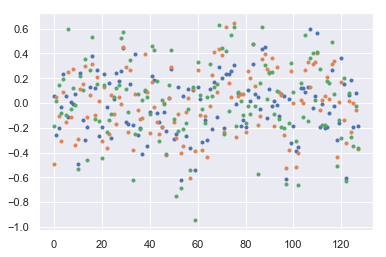

In [19]:
model.evaluate()

Model has 17804 parameters.
Data has 1280000 values.
EPOCH    10: NLL 4631.85840 KL(Q||P) 773.36761 -ELBO 5405.22607
EPOCH    20: NLL 2466.77954 KL(Q||P) 1021.03815 -ELBO 3487.81763
EPOCH    30: NLL 1651.07288 KL(Q||P) 1168.06494 -ELBO 2819.13770
EPOCH    40: NLL 1464.66492 KL(Q||P) 1106.52881 -ELBO 2571.19385
EPOCH    50: NLL 1215.00964 KL(Q||P) 1163.53711 -ELBO 2378.54688
EPOCH    60: NLL 1261.13525 KL(Q||P) 1069.55164 -ELBO 2330.68701
EPOCH    70: NLL 1079.25220 KL(Q||P) 1139.65930 -ELBO 2218.91162
EPOCH    80: NLL 913.76923 KL(Q||P) 1279.20667 -ELBO 2192.97583
EPOCH    90: NLL 896.54889 KL(Q||P) 1213.53650 -ELBO 2110.08545
EPOCH   100: NLL 823.57074 KL(Q||P) 1257.40186 -ELBO 2080.97266


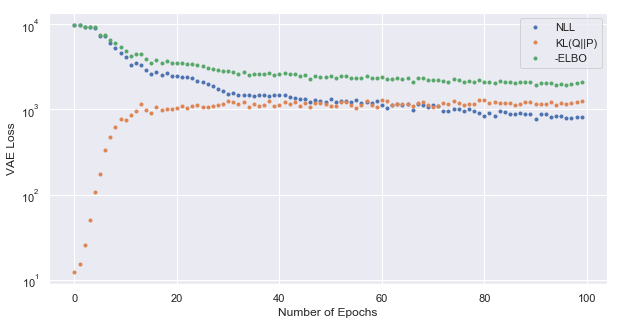

In [20]:
losses, mu, sigma = model.learn(train_data, learning_rate=0.00005, n_print=10);

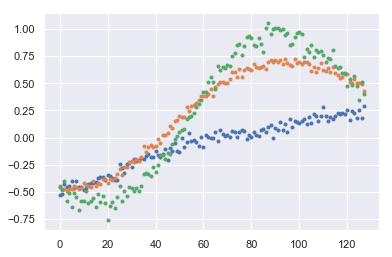

In [21]:
model.evaluate()

Check the distribution of means for the inferred posterior associated with each sample, which roughly corresponds to the autoencoder's latent variables:

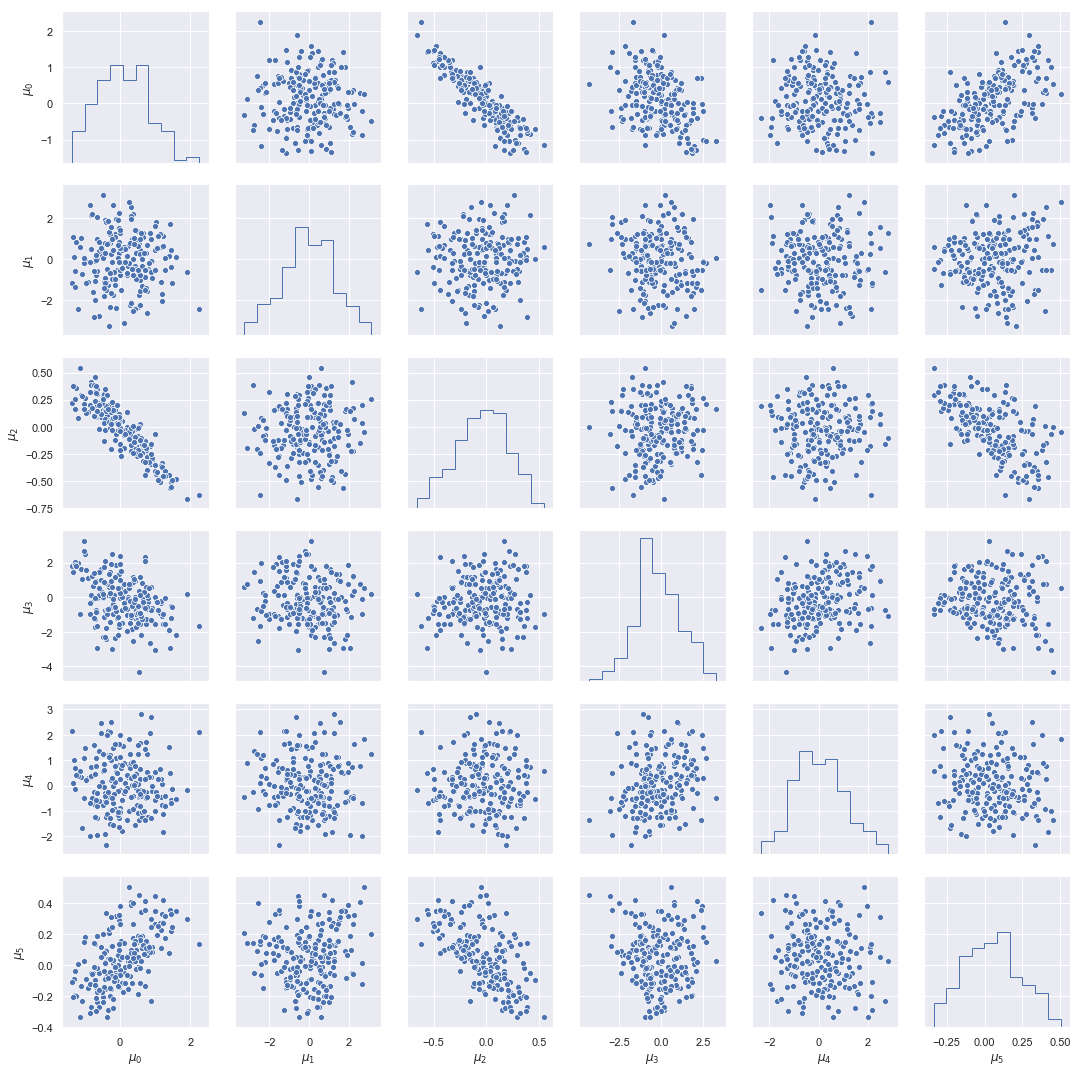

In [22]:
df = pd.DataFrame(mu[:200].numpy(), columns=[f'$\mu_{k}$' for k in range(6)])
sns.pairplot(df, diag_kind='hist', diag_kws={'histtype': 'step'});

Note that most of these means are roughly centered on zero with unit variance and uncorrelated, as expected since the generator is trying to explain the data using a fixed unit normal prior. However, there are some discrepancies which indicate that further training (or model refinement) are necessary.

In [23]:
df.describe(percentiles=[])

,$\mu_0$,$\mu_1$,$\mu_2$,$\mu_3$,$\mu_4$,$\mu_5$
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.100861,-0.042384,-0.040175,-0.202560,0.061948,0.050972
std,0.705232,1.278472,0.240711,1.290788,1.036576,0.182818
min,-1.360511,-3.248311,-0.660596,-4.300436,-2.321658,-0.336112
50%,0.064376,0.000997,-0.027260,-0.285491,-0.034824,0.051850
max,2.246069,3.113004,0.540628,3.245141,2.813818,0.501325


**DISCUSS:** Is there a limit in which a VAE is equivalent to an autoencoder, i.e., with inputs that are effectively directly connected to outputs (via a small latent layer)?

#### VAE Theory

The first (reducing) half of a VAE network encodes each input sample $\mathbf{x}$ with two parameters $\mu$ and $\sigma$ that define a normal distribution in the (smaller) latent space. We can interpret this normal distribution $Q(\mathbf{z})$ as an estimate of the posterior probability density
$$
Q(\mathbf{z}; \Theta) \simeq P(\mathbf{z}\mid \mathbf{x})
$$
where the latent variables $\mathbf{z}$ play the role of our model parameters and $\Theta$ represents the weights and biases that determine $\mu$ and $\sigma$. Learning $Q$ by varying $\Theta$ is therefore equivalent to finding the the "best" variational approximation $Q(\mathbf{z}; \Theta)$ to the true posterior $P(\mathbf{z}\mid \mathbf{x})$. This is the variational inference method we covered [earlier](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Variational.ipynb), where we saw that the KL divergence between $Q$ and $P$ is a good definition of "best", and that it is equivalent to minimize the negative ELBO:
$$
-\text{ELBO} = \langle \log P(\mathbf{x}\mid \mathbf{z})\rangle_{z\sim Q} +
\text{KL}\left(Q(\mathbf{z};\Theta) \parallel P(\mathbf{z})\right) \; ,
$$
where $P(\mathbf{z})$ is our assumed prior on the latent space. Note that a VAE attempts to find a $\Theta$ that does a good job of approximating the posterior for *any* input $\mathbf{x}$, rather than for just one observation.

The first term of the -ELBO is the average negative-log-likelihood of $\mathbf{x}$ for model parameters $\mathbf{z}$ drawn from the normal distribution $Q$ (with $\mu$ and $\sigma$ calculated by the network). We could estimate this with many samples drawn from $Q$ for each input $\mathbf{x}$ but, in practice, it is sufficient to use a single sample $\mathbf{z}$ and let the many iterations of training provide the necessary ensemble averaging.

What is the likelihood $P(\mathbf{x}\mid\mathbf{z})$? We use the second (expanding) network to estimate this quantity, by trying to reconstruct $\mathbf{x}$ from the sample $\mathbf{z}\sim Q$. A sample $\mathbf{x}$ has high likelihood if it can be accurately reconstructed via the chain:
$$
\mathbf{x}_\text{in} \rightarrow (\mu,\sigma) \rightarrow \mathbf{z}\sim {\cal N}(\mu, \sigma)
\rightarrow \mathbf{x}_\text{out} \; .
$$
We can measure reconstruction accuracy with the $L_2$ loss,
$$
L_2\left(\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) =
\left| \mathbf{x}_\text{out} - \mathbf{x}_\text{in}\right|^2 \; ,
$$
which equals the negative-log-likelihood (up to a constant) under the assumption that the uncertainties in each input feature are all drawn from the same normal distribution with variance $\sigma_x^2$,
$$
-\log P(\mathbf{x_\text{in}}\mid \mathbf{z}) = \frac{1}{2\sigma_x^2} L_2\left(
\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) \; .
$$
In practice, this assumption is not strictly valid but we still use $L_2$ as a proxy for the likelihood and replace $1/(2\sigma_x^2)$ with an additional hyperparameter $\alpha$:
$$
-\log P(\mathbf{x_\text{in}}\mid \mathbf{z}) \simeq \alpha L_2\left(
\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) \; .
$$
Note that when you know something about the input errors, you may be able to build a more accurate likelihood proxy.

The second term of the -EBLO is the KL divergence between $Q$ and our assumed prior, which we chose to be a unit normal so that this term can be calculated analytically:
$$
\text{KL}\left(Q(\mathbf{z};\Theta) \parallel P(\mathbf{z})\right) =
\frac{1}{2} \sum_i \left( \mu_i^2 + \sigma_i^2 - \log\sigma_i^2 - 1\right) \; ,
$$
where the sum is over the latent dimensions of $\mathbf{z}$.

Refer back to the diagram and code above to see how we construct a loss function that approximates the -ELBO, so our training loop is effectively performing variational inference to find neural network parameters (not to be confused with the probabilistic model parameters $\mathbf{z}$) that are best able to explain the data using a combination of posterior inference in $\mathbf{z}$ and reconstruction $\mathbf{z}\rightarrow\mathbf{x}$.

Note that by fixing the prior to a unit normal, we are reversing the way we normally build a model, which is to define the parameters first then chose a suitable prior. Instead, here we are specifying the prior first and then learning a set of parameters that can explain the data with this prior.

### Generative Adversarial Networks (GAN)

A GAN consists of two separate models:
 - A **discriminator** whose job is to classify samples as being real or fake.
 - A **generator** whose job is to map a point $\mathbf{z}$ in the latent space to a corresponding sample $\mathbf{x}$.
 
![generative adversarial architecture](img/NeuralNetworks/generative-adversarial.png)

The discriminator (D) and generator (G) are both randomly initialized, then carefully trained together so that they both gradually improve together. For each minibatch of the training data we:
 - Generate a corresponding batch of fake samples.
 - Use the discriminator on both the fake and real samples.
 
We need two loss functions, one for each model.  Both losses measures the classification accuracy of the discriminator (using [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss)):
 - D loss: reward correct classification of both fake and real samples.
 - G loss: reward incorrect classification of fake samples.
 
The ultimate product of a GAN is its generator, and we only use the discriminator to coach the generator. The GAN design is relatively immune to overfitting since the generator is only ever fed random numbers and never directly sees any of the training samples.
 
Here is an implementation for our test problem:

In [24]:
class GAN(object):
    
    def __init__(self, n_data=128, n_latent=6, z_norm=False):
        self.n_latent = n_latent
        # The discriminator calculates the probability (as a logit) that a sample is real.
        self.D = torch.nn.Sequential(
            torch.nn.Linear(n_data, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, 1),
        )
        # The generator maps samples in the latent space to the data space.
        self.G = torch.nn.Sequential(
            torch.nn.Linear(n_latent, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, n_data),
        )
        print(f'D has {np.sum([np.prod(P.shape) for P in self.D.parameters()])} parameters.')
        print(f'G has {np.sum([np.prod(P.shape) for P in self.G.parameters()])} parameters.')
        self.eval_z = None
        self.z_norm = z_norm
        
    def get_z(self, n):
        if self.z_norm:
            return torch.randn((n, self.n_latent))
        else:
            return torch.rand((n, self.n_latent))
        
    def evaluate(self, n_eval=3, fixed_z=True):
        self.D.eval()
        self.G.eval()
        # Generate n_eval fakes.
        if self.eval_z is None or not fixed_z:
            self.eval_z = self.get_z(n_eval)
        x = self.G(self.eval_z).detach()
        # Classify each fake sample.
        prob = torch.sigmoid(self.D(x)).detach().squeeze().numpy()
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        # Plot each generated fake labeled with its discriminator probability.
        for i in range(n_eval):
            ax[0].plot(x[i].numpy(), '.', label=f'prob={prob[i]:.5g}')
        ax[0].legend()
        # Fetch the first n_eval samples from the test data.
        x = test_data.tensors[0][:n_eval]
        # Classify each real sample.
        prob = torch.sigmoid(self.D(x)).detach().squeeze().numpy()
        # Plot the first
        for i in range(n_eval):
            ax[1].plot(x[i].numpy(), '.', label=f'prob={prob[i]:.5g}')
        ax[1].legend()
        
    def learn(self, data, n_epochs=200, batch_size=200, D_lr=0.0005, G_lr=0.0005, n_print=1):
        self.D.train()
        self.G.train()
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        D_optimizer = torch.optim.Adam(self.D.parameters(), lr=D_lr)
        G_optimizer = torch.optim.Adam(self.G.parameters(), lr=G_lr)
        D_losses, G_losses = [], []
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        loss_fn = torch.nn.BCEWithLogitsLoss()
        all_real = torch.ones((batch_size, 1))
        all_fake = torch.zeros((batch_size, 1))
        for epoch in range(n_epochs):
            for x_real, _ in loader:
                
                # -- Train the generator ----------------------
                
                # Generate random latent variables for each sample in this minibatch.
                z = self.get_z(batch_size)
                
                # Generate a minibatch of fake samples.
                x_fake = self.G(z)
                
                # Reward the generator for producing fakes that fool the discriminator.
                G_loss = loss_fn(self.D(x_fake), all_real)

                # Update the generator parameters.
                G_optimizer.zero_grad()
                G_loss.backward()
                G_optimizer.step()
                
                # -- Train the discriminator ------------------
                
                # Detach the fake samples from the generator parameters so we can train
                # the discriminator independently.
                x_fake.detach_()

                # Reward the discriminator for correctly classifying fake and real samples.
                D_real_loss = loss_fn(self.D(x_real), all_real)
                D_fake_loss = loss_fn(self.D(x_fake), all_fake)
                D_loss = (D_real_loss + D_fake_loss) / 2

                # Update the discriminator parameters.
                D_optimizer.zero_grad()
                D_loss.backward()
                D_optimizer.step()

            D_losses.append(float(D_loss.data))
            G_losses.append(float(G_loss.data))
            if epoch + 1 == print_at[0]:
                print(f'EPOCH {epoch + 1:5d}: D {D_losses[-1]:.5f} G {G_losses[-1]:.5f}')
                print_at = print_at[1:]
        plt.figure(figsize=(10, 5))
        plt.plot(D_losses, '.', label='D')
        plt.plot(G_losses, '.', label='G')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Adversarial Loss')
        plt.yscale('log')
        plt.legend()
        return D_losses, G_losses

Create a new GAN model for our test problem with a 6D latent space:

In [25]:
torch.manual_seed(123)
model = GAN(n_data=128, n_latent=6)

D has 8321 parameters.
G has 8768 parameters.


The initial generator's samples are random noise and the initial discriminator guesses that all samples are ~50% likely to be real:

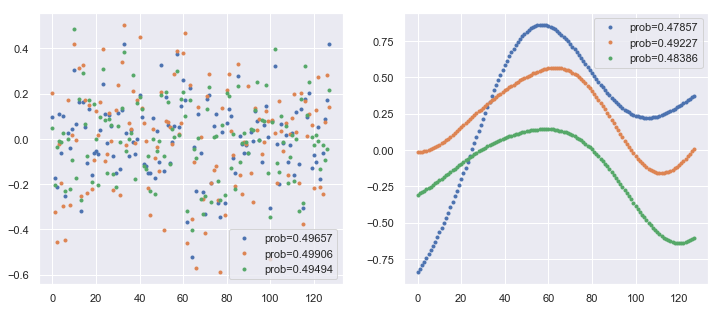

In [26]:
model.evaluate()

Successful learning requires that the separate generator (G) and discriminator (D) losses are comparable, and co-learn to maintain this "adversarial" balance, with neither gaining a clear advantage in this neural-network arms race. This requires some fine tuning and can be challenging to setup and maintain.

Note that we are not looking for decreasing loss curves when training a GAN! We also do not use a TEST sample to monitor progress. Notice how the two losses curves mirror each other below (on a log scale). The measure of GAN performance is how representative its generated samples are of the input sample distribution.

Data has 1280000 values.
EPOCH   200: D 0.62770 G 0.89600


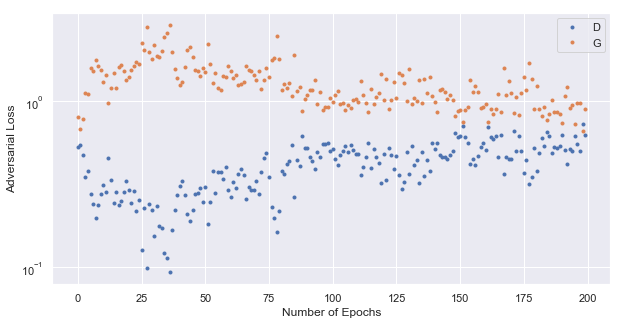

In [27]:
model.learn(train_data, D_lr=0.0005, G_lr=0.0005);

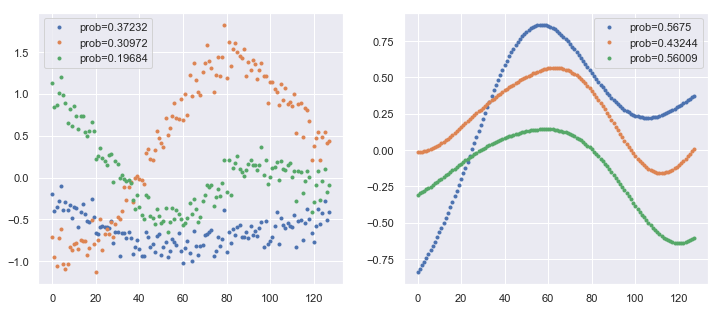

In [28]:
model.evaluate()

To illustrate how fragile GAN learning can be, repeat the previous study for the same model but using different training hyperparameters:

D has 8321 parameters.
G has 8768 parameters.
Data has 1280000 values.
EPOCH   200: D 0.02584 G 4.35668


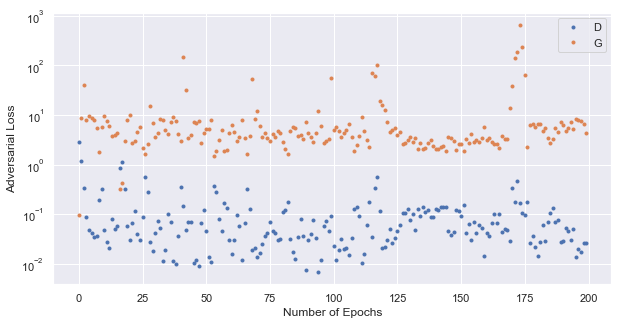

In [29]:
torch.manual_seed(123)
model = GAN(n_data=128, n_latent=6)
model.learn(train_data, D_lr=0.005, G_lr=0.005);

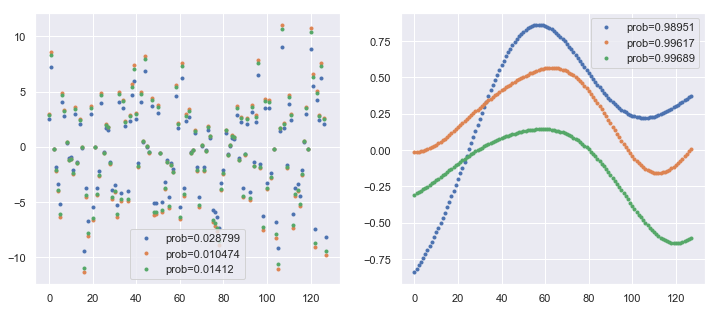

In [30]:
model.evaluate()

See this [talk](https://www.youtube.com/watch?v=myGAju4L7O8) and accompanying [repo](https://github.com/soumith/ganhacks) for some practical advice on training GANs.

**DISCUSS:** Which component (G or D) has effectively won this adversarial contest, preventing further learning? What evidence supports your answer?

**ANSWER:** The discriminator has won. The evidence for this is:
 - The final D loss is ~0.01 while the final G loss is ~100.
 - The final D classifications are essentially perfect: ~0 for the fakes and ~1 for the real samples.
 - The final G samples are highly correlated and indistinguishable from noise.

### Flow Models

The methods above have relatively complicated loss functions. Why don't we directly maximize how well the model explains the data instead? The obvious approach would be to find optimize the (negative log) likelihood of the input data with respect to the model:
$$
-\log{\cal L}(X\mid \Theta) = -\frac{1}{N} \sum_{k=1}^N\, \log P(\mathbf{x}_i\mid \Theta) \; .
$$
The challenge with this approach is how to estimate the log-likelihood $\log P(\mathbf{x}_i\mid \Theta)$ of each input sample $\mathbf{x}_i$.

A "flow-based" model is a neural network that calculates this log-likelihood directly, but this requires a special architecture since a random network $F(X; \Theta)$ is extremely unlikely to satisfy the conditions for being a probability density:
 - Value is always positive: $F(\mathbf{x}; \Theta) \ge 0$.
 - Integral of values over the full input domain equals one: $\int F(\mathbf{x}; \Theta)\,d\mathbf{x} = 1$.
 
The key idea of a flow model is to start with a simple (analytic) base probability density $Q$ (usually a multivariate Gaussian) and then smoothly distort it until to better explain the data. The role of the network is then to apply the distortion, rather than calculate the probability density itself.

We can summarize the model so far as:
$$
\mathbf{x} \sim P \quad, \quad \mathbf{q} \sim Q \quad, \quad \mathbf{x} = F(\mathbf{q}\mid\Theta) \; ,
$$
where $F$ is the function calculated by the neural network:

![normalizing flow architecture](img/NeuralNetworks/normalizing-flow.png)

We can now calculate the log-likelihood using a change of variables (and some calculus) as:
$$
\log P(\mathbf{x}) = \log Q(F^{-1}(\mathbf{x}) +
\log\left|\det\frac{\partial}{\partial\mathbf{q}}F^{-1}(\mathbf{x})\right| \; ,
$$
where the last term is a Jacobian determinant. Therefore we still have some special requirements on our network $F$:
 - $F(\mathbf{x})$ must be invertible, and
 - both the inverse and its Jacobian determinant must be efficient to calculate.
 
This is a rapidly developing research area with many models recently proposed (RealNVP, NICE, Glow, MAF, IAF, ...). What they have in common is that they break the network $F$ down into a chain of smaller pieces with some learnable parameters, and which satisfy the requirements above by construction.

While VAEs and GANs are generative models, these are probabilistic models. However, they can also be used as generative models, simply by feeding random samples $\mathbf{q}\sim Q$ from the base distribution backwards through $F$ to obtain a corresponding $\mathbf{x}\sim P$. Some of the proposed models (IMAF in particular) are optimized for this generative mode, at the expense of efficient probability density estimation.
 
For a deeper dive on flow generative models, see this [blog post](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html).